In [32]:
from joblib import load 
from VisionUtils import *
from Manager import *
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [33]:
tf.enable_eager_execution()

In [34]:
feature_extractor = load_model("Models/FaceNet/facenet_keras.h5")
face_detector = MTCNN()
selector = load("demo/PipelineParts/feature_selector.joblib")
scaler = load("demo/PipelineParts/scaler.joblib")
gboost = load("demo/PipelineParts/GboostModel.joblib")

W0813 12:58:03.529001 19900 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [35]:
def transform(f1, f2):
    cos_d = np.array(feat_distance_cosine_scalar(f1, f2.T))
    cos_d = cos_d.reshape(-1,1)
    sqr_diff = np.power(np.abs(f1- f2), 2)
    data = np.hstack([cos_d, sqr_diff])
    scaled_data = scaler.transform(data)
    data_ = selector.transform(scaled_data)
    return data_

### Test not betsy
def verify(img_path, f1):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    bb = detect_faces(img, face_detector)
    f2 = extract_feature(feature_extractor, img, bb[0])
    pred = gboost.predict(transform(f1,f2))

    if (int(pred) == 1):
        isbetsy = "betsy"
    else:
         isbetsy = "not betsy"
    
    
    a = show_img(img)
    draw_bb(a, bb[0])
    write_txt(a, (bb[0][0], bb[0][1]), isbetsy)

Add a person

In [36]:
### Load in ground truth image here
img = cv2.imread("demo/betsy/img1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
bb = detect_faces(img, face_detector)

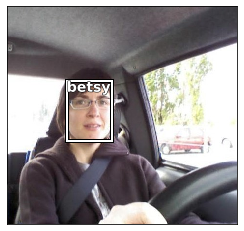

In [37]:
a = show_img(img)
draw_bb(a, bb[0])
write_txt(a, (bb[0][0], bb[0][1]),"betsy" )

In [38]:
f1 = extract_feature(feature_extractor, img, bb[0])

In [39]:
### Example input image for
path = "demo/not_betsy/img470.jpg"

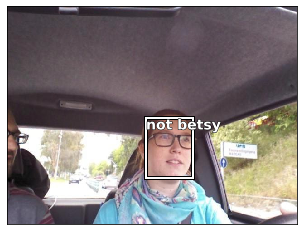

In [40]:
verify(path,f1)

In [41]:
path1 = "demo/not_betsy/img580.jpg"

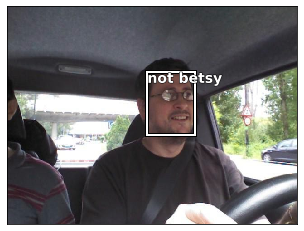

In [42]:
verify(path1, f1 )

In [43]:
path2 = "demo/betsy/img10.jpg"

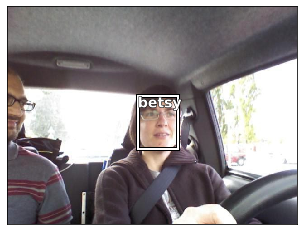

In [44]:
verify(path2, f1 )

In [45]:
   
DATABASE_PATH = "demo/database/pics/"
img_list = os.listdir(DATABASE_PATH)


In [46]:
impath = DATABASE_PATH+ img_list[0]

In [47]:
m = MTCNN()
def get_feat(face_detector , feature_extractor,  impath):
    img = plt.imread(impath)
    bb_lst = detect_faces(img, face_detector)
    if (len(bb_lst)>1):
        print("Error: more than one person detected in image")
        print("please esure only one person is in the image or try another")
    feature = extract_feature(feature_extractor, img,bb_lst[0])    
    return feature

f1 = get_feat(m, feature_extractor, DATABASE_PATH+"tyrel.jpg")
f2 = get_feat(m, feature_extractor, DATABASE_PATH+"kevon.jpg")
pred = gboost.predict(transform(f1,f2))

print(pred)

Code Test 

img = plt.imread(DATABASE_PATH+"kevon.jpg")

bb_lst = detect_faces(img, face_detector)
b = bb_lst[0]
img = cv2.rectangle(img,(b[0],b[1]),(b[0] + b[2],b[1]+ b[3]),(0,255,0),3)
plt.imshow(img)
if (len(bb_lst)>1):
    print("Error: more than one person detected in image")
    print("please esure only one person is in the image or try another")
f1 = extract_feature(feature_extractor, img,bb_lst[0])    

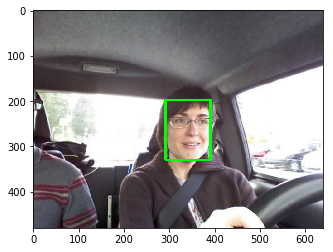

In [17]:
img = plt.imread(DATABASE_PATH+"Betsy.jpg")

bb_lst = detect_faces(img, face_detector)
b = bb_lst[0]
img = cv2.rectangle(img,(b[0],b[1]),(b[0] + b[2],b[1]+ b[3]),(0,255,0),3)
plt.imshow(img)
if (len(bb_lst)>1):
    print("Error: more than one person detected in image")
    print("please esure only one person is in the image or try another")
f2 = extract_feature(feature_extractor, img,bb_lst[0])  

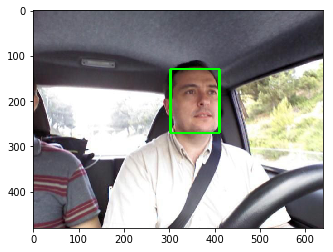

In [18]:
img = plt.imread(DATABASE_PATH+"JAKE.jpg")

bb_lst = detect_faces(img, face_detector)
b = bb_lst[0]
img = cv2.rectangle(img,(b[0],b[1]),(b[0] + b[2],b[1]+ b[3]),(0,255,0),3)
plt.imshow(img)
if (len(bb_lst)>1):
    print("Error: more than one person detected in image")
    print("please esure only one person is in the image or try another")
f2 = extract_feature(feature_extractor, img,bb_lst[0])  

In [19]:
pred = gboost.predict(transform(f1,f2))

In [20]:
pred

array([0])

In [48]:
feat_dict = {}
for path in img_list:
    feat_dict.update({path[:-4]: get_feat(m, feature_extractor, DATABASE_PATH+path) })

In [49]:
list(feat_dict.keys())

['Betsy', 'JAKE']

In [50]:
import cv2
VID_PATH = "demo/database/face_detection.avi"
cap = cv2.VideoCapture(VID_PATH)
m = MTCNN()
while(True):
    ### Capture Videos
    ret, frame = cap.read()
    
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    #cv2.imshow('vodeos', img)
    bb_lst= detect_faces(frame, m)
    
    for b in bb_lst:
        ### Draw Rectangle
        frame = cv2.rectangle( frame,(b[0],b[1]),(b[0] + b[2],b[1]+ b[3]),(0,255,0),3)
        ### Extract features from fram
        f2 = extract_feature(feature_extractor, img, b)
        
        ###Check to see if detected face is in the data base
        ### and label each bb in each frame
        for k, v in feat_dict.items():
            pred = gboost.predict(transform(v,f2))
            if (int(pred) == 1):
                name = k
                font = cv2.FONT_HERSHEY_SIMPLEX
                cv2.putText(frame,name,(b[0],b[1]), font, 4,(0,0,0),2,cv2.LINE_AA)
                break
            else:
                name = "Unknown"
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(frame,name,(b[0],b[1]), font, 4,(0,0,0),2,cv2.LINE_AA)
    ### display video captured
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    cv2.imshow('vodeos', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [23]:
for k, v in feat_dict.items():
    print(k)

tyrel


feature_extractor = load_model("Models/FaceNet/facenet_keras.h5")
face_detector = MTCNN()
selector = load("demo/PipelineParts/feature_selector.joblib")
scaler = load("demo/PipelineParts/scaler.joblib")
gboost = load("demo/PipelineParts/GboostModel.joblib")

dict1 = {
    "feature_extractor": feature_extractor,
    "face_detector": face_detector,
    "feature_selector": selector,
    "scaler": scaler,
    "classifier": gboost
}

class FaceRec:
    def __init__(self, arg_dict):
        self.featdata = {}
        self.arg_dict = arg_dict
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
    















In [65]:
cap.release()